This Jupyter notebook is for reproducing the results reported in the Manuscript. It is structured as follows:
1. Results from JSONs: Since the reported results are an average of 3 independent executions, I have saved the result JSONs for all autoencider models. These JSONs can be used without loading the image data. They are also used for creating the loss plots included in the Manuscript.
    - Modeling results
    - Experiment results
2. Saved models: I have saved the best performing models for the baselines and autoencoders, which can be loaded and run directly on the image data.
    - Baselines
    - Autoencoders without temporal encodings
    - Autoencoders with temporal encodings
    - Experiment models

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')
# sys.path.append('/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/GITHUB/Master-Thesis-SITS')
scripts_path = Path("Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))
scripts_path = Path("Evaluation/").resolve()
sys.path.append(str(scripts_path))
scripts_path = Path("Modeling/").resolve()
sys.path.append(str(scripts_path))

In [2]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

from Pipeline.temporal_preprocessing_pipeline import *
from Pipeline.preprocess_script import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from scripts.data_visualiser import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.subpatch_extraction import *
from model_scripts.executions import *
from model_scripts.feature_extraction import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from evaluation_scripts.result_visualiser import *
from Experimentation.expt_scripts.expt_plots import *
import config as config

## 1. Average results reported (using JSONs)

### Main Results for the Auto-encoder models
Results using B10 tensor, and default sub-patch-to-patch threshold (0.5)
- 2D_AE and 3D_AE (without temporal encodings)
- 2D_AE_temporal_addition and 3D_AE_temporal_addition (with temporal encodings as addition)
- 3D_AE_temporal_channel with temporal encodings as channels (used for preliminary test: selecting a temporal encoding strategy)

In [3]:
model_names = ['2D_AE', '3D_AE', '2D_AE_temporal_addition', '3D_AE_temporal_channel', "3D_AE_temporal_addition"]
df_loss, df_accuracy, df_recall, df_f1, df_precision = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [8]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,2D_AE,55.74,60.66,63.93,60.110000
1,3D_AE,60.66,59.02,60.66,59.566667
2,2D_AE_temporal_addition,52.46,63.93,60.66,59.016667
3,3D_AE_temporal_channel,68.85,70.49,70.49,69.943333
4,3D_AE_temporal_addition,68.85,68.85,70.49,69.396667


In [11]:
df_precision

,Model,Precision Run 1,Precision Run 2,Precision Run 3,Precision Avg
0,2D_AE,58.70,62.22,70.97,63.963333
1,3D_AE,62.22,62.50,63.41,62.803333
2,2D_AE_temporal_addition,56.25,62.26,61.70,60.070000
3,3D_AE_temporal_channel,71.05,70.73,72.97,71.583333
4,3D_AE_temporal_addition,69.05,69.05,72.97,70.356667


In [9]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,2D_AE,77.14,80.00,62.86,73.333333
1,3D_AE,80.00,71.43,74.29,72.383333
2,2D_AE_temporal_addition,77.14,94.29,82.86,84.763333
3,3D_AE_temporal_channel,77.14,82.86,77.14,79.046667
4,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333


In [10]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,2D_AE,66.67,70.00,66.67,67.780000
1,3D_AE,70.00,66.67,68.42,67.253333
2,2D_AE_temporal_addition,65.06,75.00,70.73,70.263333
3,3D_AE_temporal_channel,73.97,76.32,75.00,75.096667
4,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333


#### Loss plots for 2D vs 3D Autoencoder Models: With and without temporal encodings as addition

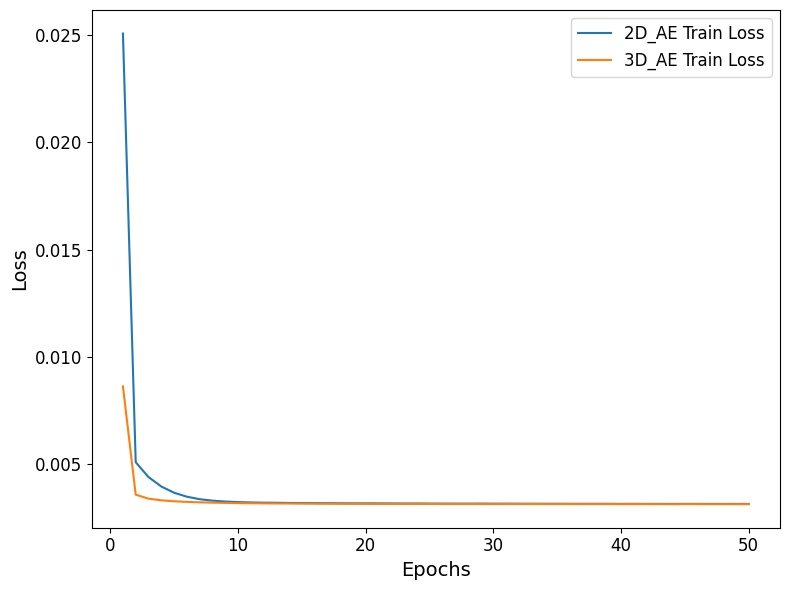

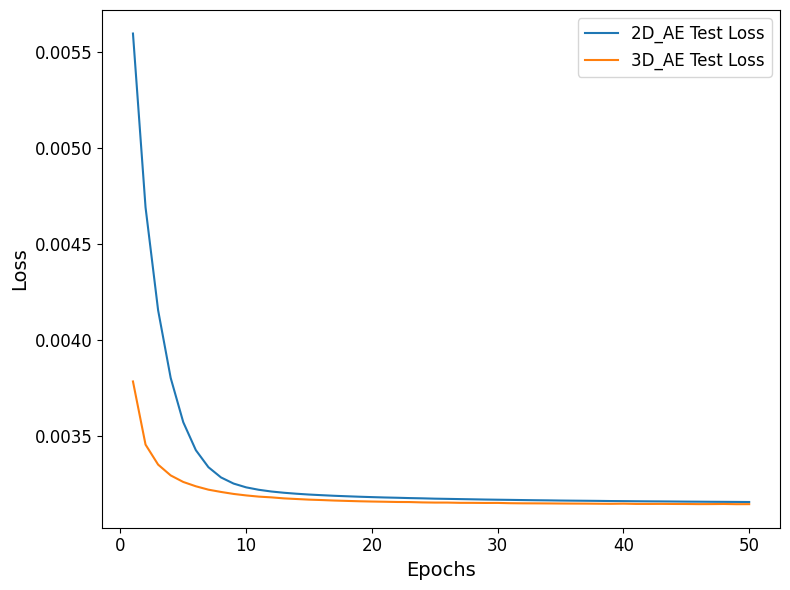

In [ ]:
model_names = ['2D_AE','3D_AE']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

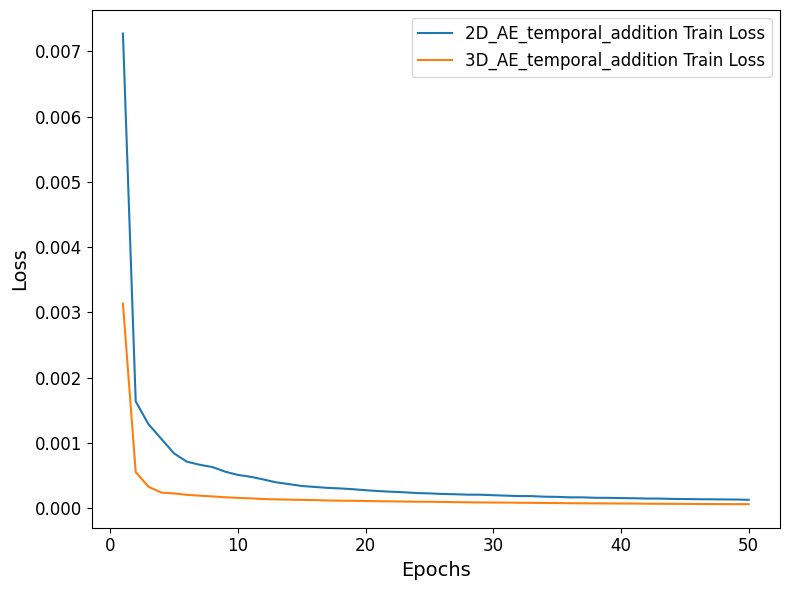

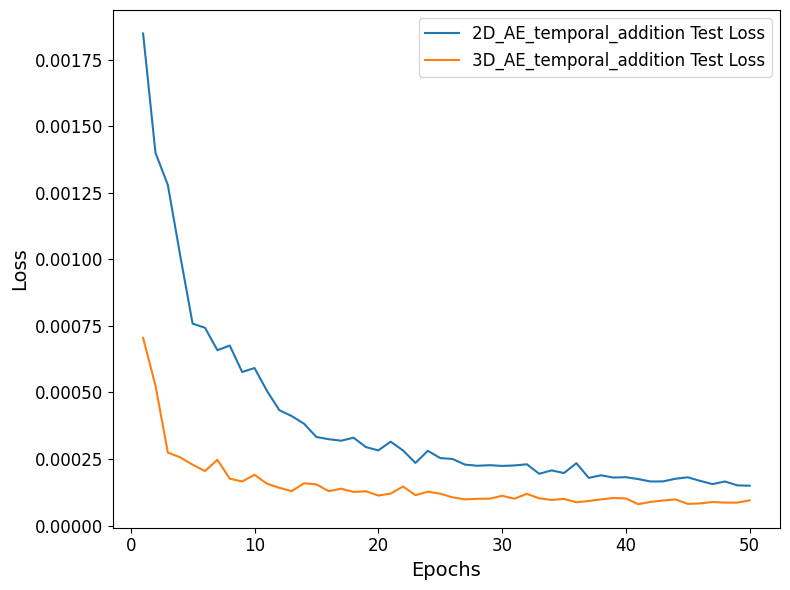

In [ ]:
model_names = ['2D_AE_temporal_addition','3D_AE_temporal_addition']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

### Results for the experiments
Experiments are performed using the 3D_AE temporal encodings addition, B10 input tensor, and sub-patch-to-patch threshold 0.5.
- Using MVI and B4 tensors 
- Changing the sub-patch size
- 2024 data

Note: Notations in the Manuscript:
- 3D_AE_temporal_addition = 3D_AE_B10 = 3D_AE_4
- 3D_AE_temporal_addition_2024 = 3D_AE_B10_2024

In [20]:
model_names = ['3D_AE_temporal_addition', '3D_AE_MVI', '3D_AE_B4', '3D_AE_8', '3D_AE_16', '3D_AE_temporal_addition_2024']
df_loss, df_accuracy, df_recall, df_f1, df_precision = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [21]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,3D_AE_temporal_addition,68.85,68.85,70.49,69.396667
1,3D_AE_MVI,59.02,50.82,47.54,52.460000
2,3D_AE_B4,68.85,68.85,44.26,60.653333
3,3D_AE_8,62.30,62.30,59.02,61.206667
4,3D_AE_16,65.57,55.74,47.54,56.283333
5,3D_AE_temporal_addition_2024,80.00,72.50,80.00,77.500000


In [22]:
df_precision

,Model,Precision Run 1,Precision Run 2,Precision Run 3,Precision Avg
0,3D_AE_temporal_addition,69.05,69.05,72.97,70.356667
1,3D_AE_MVI,60.00,55.32,53.49,56.270000
2,3D_AE_B4,69.05,68.18,51.22,62.816667
3,3D_AE_8,73.08,66.67,60.87,66.873333
4,3D_AE_16,64.00,57.69,52.94,58.210000
5,3D_AE_temporal_addition_2024,86.49,85.29,86.49,86.090000


In [23]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333
1,3D_AE_MVI,85.71,74.29,65.71,75.236667
2,3D_AE_B4,82.86,85.71,60.00,76.190000
3,3D_AE_8,54.29,68.57,80.00,67.620000
4,3D_AE_16,91.43,85.71,77.14,84.760000
5,3D_AE_temporal_addition_2024,91.43,82.86,91.43,88.573333


In [24]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333
1,3D_AE_MVI,70.59,63.41,58.97,64.323333
2,3D_AE_B4,75.32,75.95,55.26,68.843333
3,3D_AE_8,62.30,67.61,69.14,66.350000
4,3D_AE_16,75.29,68.97,62.79,69.016667
5,3D_AE_temporal_addition_2024,88.89,84.06,88.89,87.280000


#### Loss Plots
- B10 vs MVI vs B4
- Subpatch sizes 4, 8, 16

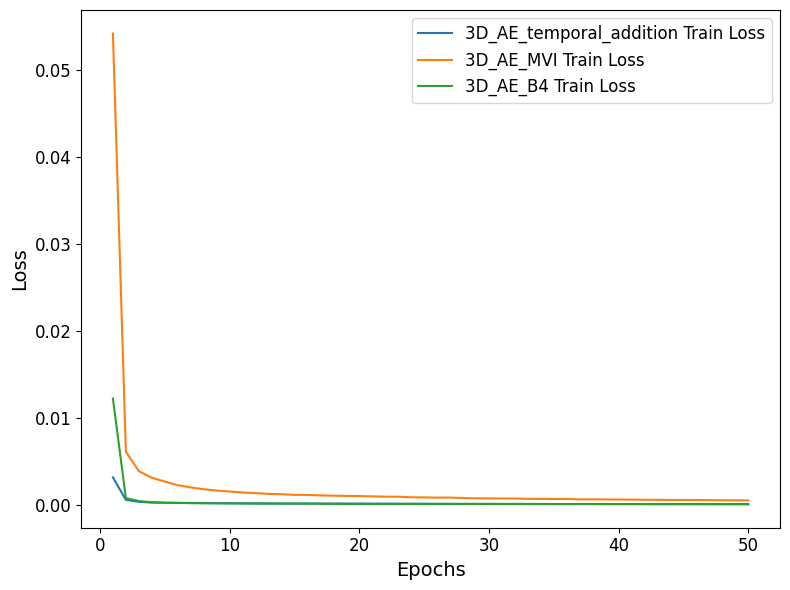

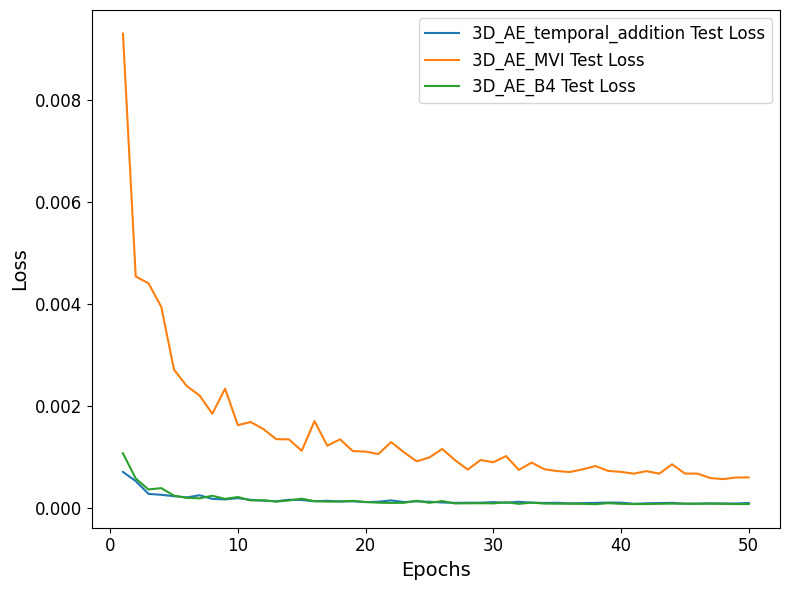

In [25]:
model_names = ['3D_AE_temporal_addition', '3D_AE_MVI', '3D_AE_B4']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

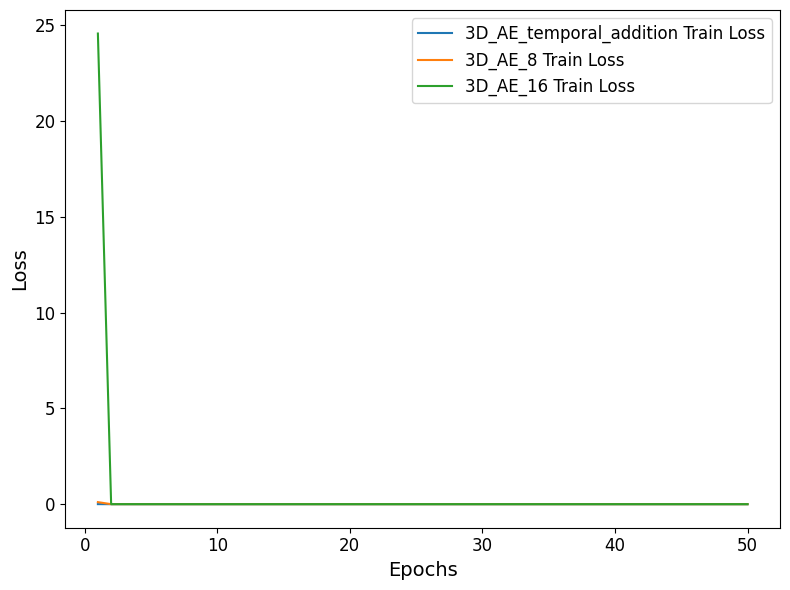

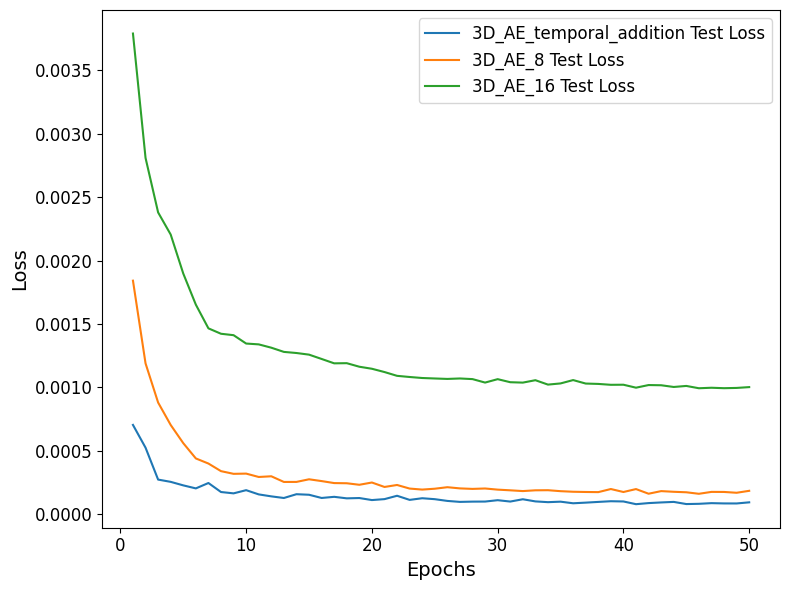

In [26]:
model_names = ['3D_AE_temporal_addition', '3D_AE_8', '3D_AE_16']
train_loss, test_loss = load_avg_losses(model_names, output_dir=config.results_json_path)
plot_losses_ae(train_loss, test_loss)

#### 2024 vs 2019 bar chart

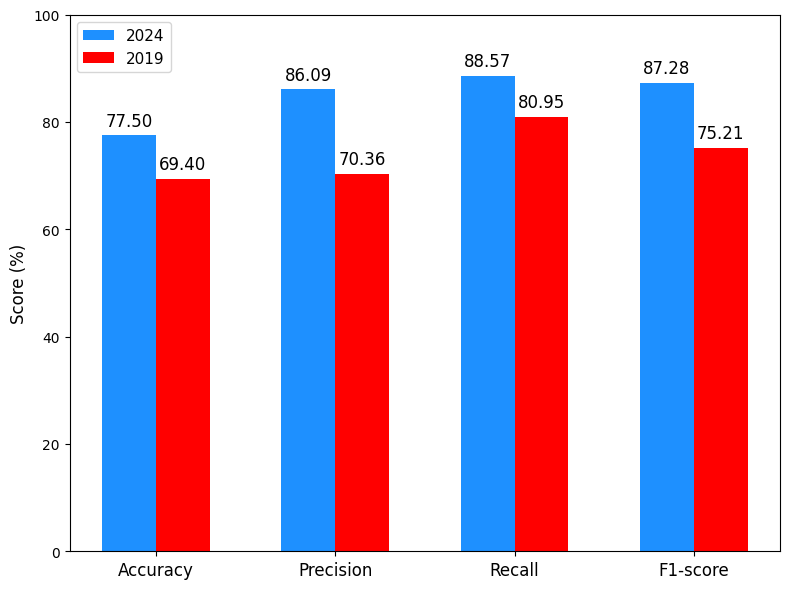

In [27]:
plot_2019_vs_2024()

## 2. Re-running the saved models

tensor_type values can be:
- 'b10' for normal b10 data
- 'b10_channel' for b10 data with 2 additional temporal encoding channels
- 'b10_add' for b10 with temporal encodings included in the dataloaders for addition during the forward pass
- 'b4_add' for b4 with temporal encodings
- 'mvi_add' for mvi with temporal encodings

model_type vlaues can be:
- baseline
- autoencoders
- autoencoders_channel
- autoencoders_addition

### Baseline Models
- k-means, k-mediods, agglomerative clustering on raw data
- Histogram features + k-means
- PCA + k_means

#### Loading 2019 data for the baselines

In [3]:
train_subpatches, eval_subpatches, train_coord_fn, eval_coord_fn = get_model_ready_data(model_type='baseline', tensor_type='b10', encoding_method='sin-cos', visualisation_images=False)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 10, 4, 4]), torch.Size([1197, 7, 10, 4, 4]))

#### Clustering raw data

In [7]:
##### K-means #####

#Load model and flatten data
with open(config.kmeans_b10_path, 'rb') as file:
    kmeans_b10 = pickle.load(file)

train_subpatch_predictions = kmeans_b10.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
eval_subpatch_predictions = kmeans_b10.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

#Metrics
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)

Disease cluster: 1
Accuracy: 63.93
Precision: 62.75
Recall: 91.43
F1-score: 74.42


/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
##### K-medoidds #####
# Need to do for k-medoids: pip install scikit-learn-extra

#Load model and flatten data
with open(config.kmedoids_path, 'rb') as file:
    kmedoids_b10 = pickle.load(file)

train_subpatch_predictions = kmedoids_b10.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmedoids_b10.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, test_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

ModuleNotFoundError: No module named 'sklearn_extra'

In [4]:
##### Agglomerative #####

#Load model and flatten data
with open(config.agg_path, 'rb') as file:
    agg_b10 = pickle.load(file)

train_subpatch_predictions = agg_b10.fit_predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = agg_b10.fit_predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, test_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 42.62
Precision: 50.0
Recall: 54.29
F1-score: 52.05
F2-score: 53.37


#### Histogram Features and PCA

In [ ]:
##### Histogram features #####
histogram_features_train = extract_global_histogram(train_subpatches, bins=30)
histogram_features_eval = extract_global_histogram(eval_subpatches, bins=30)

with open(config.kmeans_hist_path, 'rb') as file:
    kmeans_hist = pickle.load(file)

train_subpatch_predictions = kmeans_hist.predict(histogram_features_train.reshape(histogram_features_train.shape[0],-1))
eval_subpatch_predictions = kmeans_hist.predict(histogram_features_eval.reshape(histogram_features_eval.shape[0],-1))

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 63.93
Precision: 69.7
Recall: 65.71
F1-score: 67.65
F2-score: 66.47


/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
features_train, top_channel_indices_train = pca_feature_extraction_channel(train_subpatches, n_components=config.pca_components) 
features_eval, top_channel_indices_eval = pca_feature_extraction_channel(eval_subpatches, n_components=config.pca_components)
top_channel_indices_train, top_channel_indices_eval

with open(config.kmeans_pca_path, 'rb') as file:
    kmeans_pca = pickle.load(file)

train_subpatch_predictions = kmeans_pca.predict(np.array(features_train))
eval_subpatch_predictions = kmeans_pca.predict(np.array(features_eval))

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 57.38
Precision: 58.82
Recall: 85.71
F1-score: 69.77
F2-score: 78.53


### Autoencoders without temporal encodings
The results reported in the Manuscript are reported over 3 executions, which can be found in the Jupyter Notebook in Modeling section named 'temporal_ae_executions'.

The results here are by loading the saved model (best performing model over the 3 executions).
- 2D_AE_B10
- 3D_AE_B10

#### Loading 2019 data for the autoencoders

In [5]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders', tensor_type='b10', encoding_method='sin-cos', visualisation_images=False)

#### 2D_AE_B10

In [6]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed

In [7]:
#Load models
channels = 10
time_steps = 7
latent_dim = 32
device = 'cuda'
trained_model = Conv2DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

with open(config.ae_2D_path, 'rb') as file:
    trained_model = pickle.load(file)

with open(config.kmeans_ae_2D_path, 'rb') as file:
    kmeans = pickle.load(file)

/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
#Extract features -> k-means -> evaluation
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 60.66
Precision: 66.67
Recall: 62.86
F1-score: 64.71
F2-score: 63.58


#### 3D_AE_B10

In [11]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [13]:
#Load models
channels = 10
time_steps = 7
latent_dim = 32
device = 'cuda'
trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
with open(config.ae_3d_path, 'rb') as file:
    trained_model = pickle.load(file)

with open(config.kmeans_ae_3D_path, 'rb') as file:
    kmeans = pickle.load(file)

/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 63.93
Precision: 66.67
Recall: 74.29
F1-score: 70.27
F2-score: 72.63


### Autoencoders with temporal encodings
The results reported in the Manuscript are reported over 3 executions, which can be found in the Jupyter Notebook in Modeling section named 'temporal_ae_executions'.

The results here are by loading the saved model (best performing model over the 3 executions).
- 2D_AE_B10 with temporal encodings as addition
- 3D_AE_B10 with temporal encodings as addition
- 3D_AE_B10 with temporal encodings as channels (for preliminary test)

#### 2D_AE_B10 with temporal encoding addition

In [18]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_addition', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

In [22]:
class Conv2DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder_Time_Addition, self).__init__()

        self.in_channels = in_channels
        self.time_steps = time_steps
        self.patch_size = patch_size

        # --- Temporal embedding projection to match input shape before flattening ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)  # from (B, 2, T, H, W) to (B, C, T, H, W)

        # --- Encoder ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x, date_embeddings):
        b, c, t, h, w = x.shape  # (B, C, T, H, W)

        # --- Process date embeddings ---
    
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)
        else:
            date_embeddings = date_embeddings.to(x.device)

        temb = date_embeddings.permute(0, 2, 1).unsqueeze(-1).unsqueeze(-1)  # (B, 2, T, 1, 1)
        temb = temb.expand(-1, -1, -1, h, w)                                 # (B, 2, T, H, W)
        temb = self.temb_proj(temb)                                         # (B, C, T, H, W)

        # --- Add temporal encodings ---
        x = x + temb                                                        # (B, C, T, H, W)

        # --- Reshape for 2D conv (treat time as channel) ---
        x = x.reshape(b, c * t, h, w)                                       # (B, C*T, H, W)

        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Latent bottleneck ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = x.view(b, 256, h, w)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)  # Reshape back

        return z, x_reconstructed


In [27]:
#Load models
channels = 10
time_steps = 7
latent_dim = 32
device = 'cuda'
trained_model = Conv2DAutoencoder_Time_Addition(channels, time_steps, latent_dim, config.subpatch_size)

with open(config.ae_2D_TE_path, 'rb') as file:
    trained_model = pickle.load(file)

# with open(config.kmeans_ae_2D_TE_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [28]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=26)   #skip when using saved model

In [ ]:
#Extract features -> k-means -> evaluation
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=True, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=True, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=True, device=device)
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl
train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

In [ ]:
trained_model.to('cpu')
with open(config.kmeans_ae_2D_TE_path, 'wb') as file:
    pickle.dump(kmeans, file)

